In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Heart Disease Analysis & Dimensionality Reduction

#### **Objectives:**

1. **Exploratory Data Analysis (EDA):**  
   - Identify potential patterns and relationships between clinical variables and disease status.
   - Understand feature distributions and correlations in the heart disease dataset.

2. **Unsupervised Machine Learning:**  
   - Use **t-SNE** to visualize local clustering and nonlinear separability between heart disease classes. 
   - Apply **Principal Component Analysis (PCA)** to reduce dimensionality and interpret feature importance. 
   
3. **Supervised Modeling (XGBoost):**  
   - Train a classifier to predict heart disease status based on clinical features.  
   - Evaluate feature importance using Gain to identify key predictors.  
   - Compare supervised and unsupervised insights to validate feature importance for clinical decision-making.


### 1. Heart Disease Exploratory Data Analysis

This code analyzes a clinical dataset containing patient information related to heart disease. The `target` column indicates the presence (`1`) or absence (`0`) of heart disease. 
Summary statistics and visualizations are used to evaluate differences between these two groups, with the goal of identifying key features associated with heart disease risk.


**Code Block 1:** Reads in the heart disease dataset and generates a summary statistics table grouped by heart disease status (`target`). This grouped statistics DataFrame (`grouped_stats`) will be used to compare feature distributions between patients with (`target = 1`) and without (`target = 0`) heart disease in subsequent analysis steps.


In [2]:
heart = pd.read_csv("heart.csv")
#heart.head()
grouped_stats = heart.groupby("target").describe()
grouped_stats.columns = ['_'.join(col).strip() for col in grouped_stats.columns.values]
grouped_stats.reset_index(inplace=True)
grouped_stats

,target,age_count,age_mean,age_std,age_min,age_25%,age_50%,age_75%,age_max,sex_count,...,ca_75%,ca_max,thal_count,thal_mean,thal_std,thal_min,thal_25%,thal_50%,thal_75%,thal_max
0,0,499.0,56.569138,7.908153,35.0,52.0,58.0,62.0,77.0,499.0,...,2.0,4.0,499.0,2.539078,0.685460,0.0,2.0,3.0,3.0,3.0
1,1,526.0,52.408745,9.631804,29.0,44.0,52.0,59.0,76.0,526.0,...,0.0,4.0,526.0,2.119772,0.468949,0.0,2.0,2.0,2.0,3.0


**Code Block 2:** Loops through selected clinical features (`age`, `trestbps`, `chol`, `thalach`) and generates density histograms stratified by heart disease status. These visualizations help identify differences in feature distributions between the two patient groups.


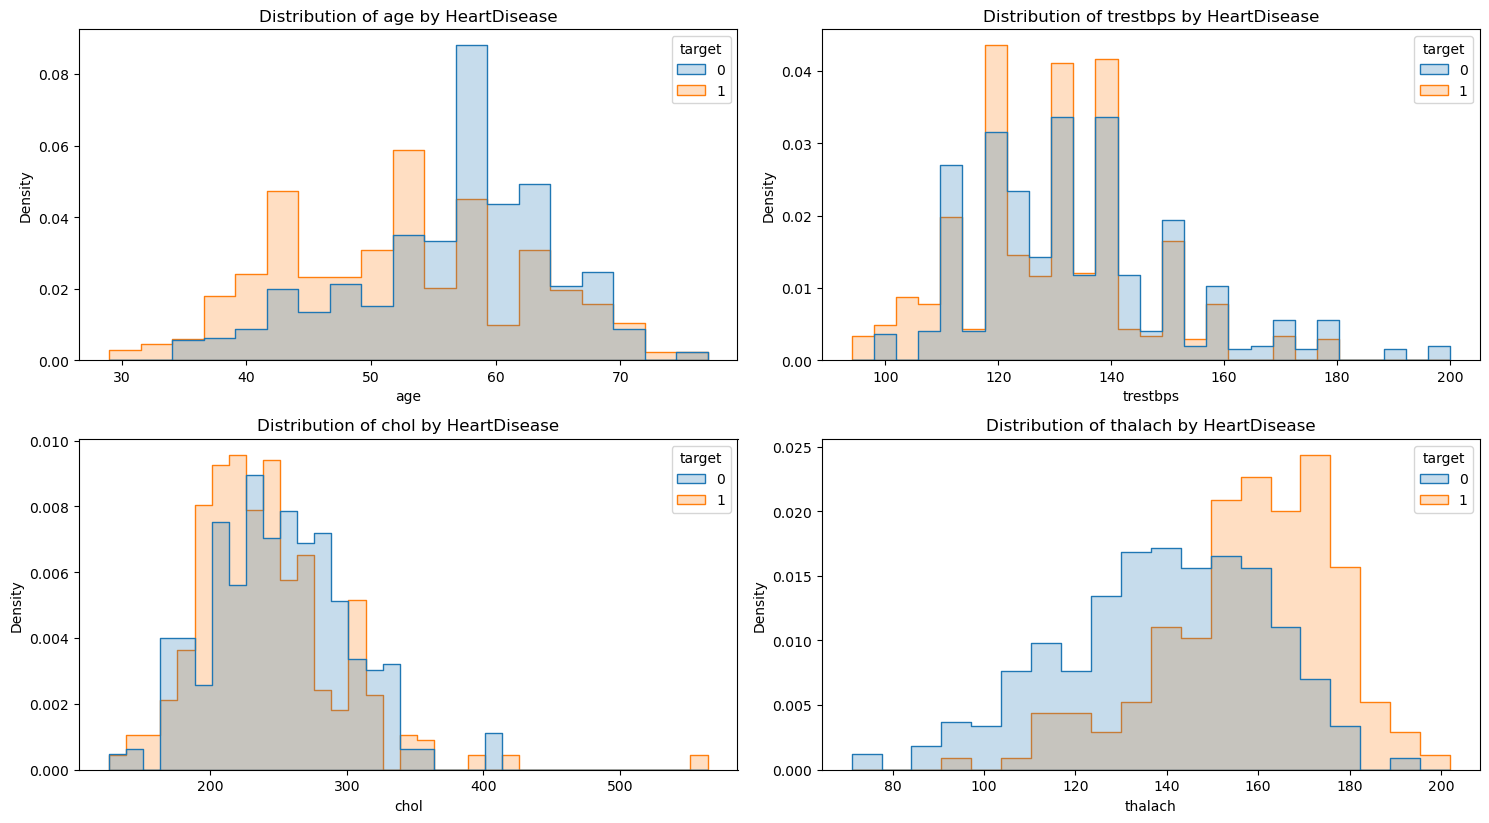

In [3]:
features_to_plot = ["age","trestbps","chol", "thalach"]

plt.figure(figsize=(15,12))

for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(3,2,i)
    sns.histplot(data=heart, x = feature, hue="target", element="step", stat="density", common_norm=False)
    plt.title(f'Distribution of {feature} by HeartDisease')
    plt.xlabel(feature)
    plt.ylabel('Density')

plt.tight_layout()
plt.show()

**Code Block 3:** Creates and visualizes the correlation matrix for all numeric features in the dataset using a heatmap. This will help identify relationships between variables and potential multicollinearity, which may affect future statistical testing/machine learning models. 

Additionally, the mean values of each numeric feature are compared across heart disease status (`target = 0` vs `target = 1`) to highlight differences between healthy and affected patients.


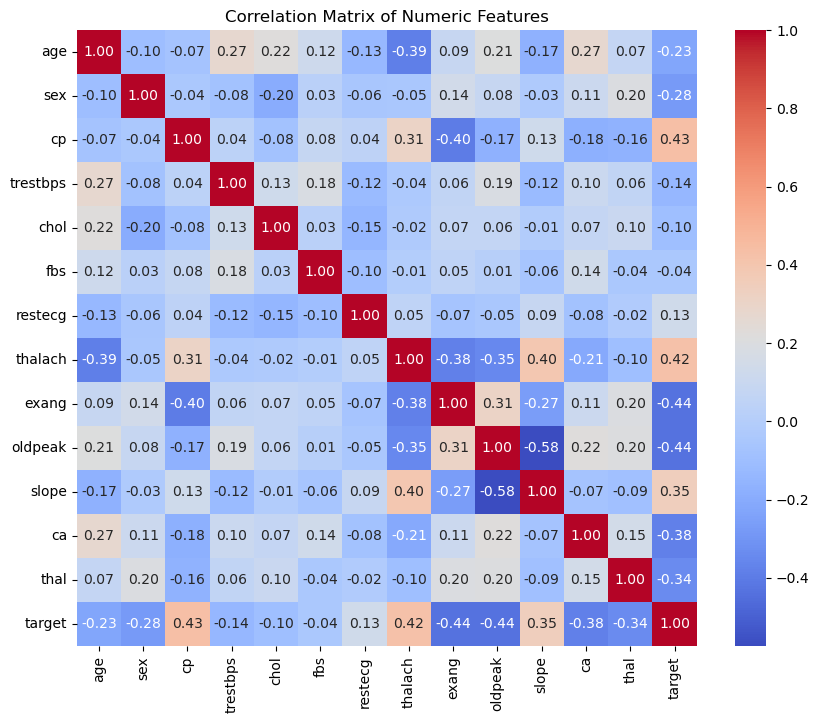

target,0,1
age,56.569138,52.408745
sex,0.827655,0.570342
cp,0.482966,1.378327
trestbps,134.106212,129.245247
chol,251.292585,240.979087
fbs,0.164329,0.134981
restecg,0.456914,0.598859
thalach,139.130261,158.585551
exang,0.549098,0.134981
oldpeak,1.600200,0.569962


In [4]:
heart_numeric = heart.select_dtypes(include="number")
heart_corr = heart_numeric.corr()

plt.figure(figsize=(10,8))
sns.heatmap(heart_corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Numeric Features")
plt.show()

numeric_features = heart_numeric.columns.drop("target")
group_means = heart.groupby("target")[numeric_features].mean().T
group_means


**Code Block 4:** Generates a grouped barplot comparing the mean values of `age`, `trestbps`, `chol`, `thalach` across heart disease status (`target` = 0 vs `target` = 1). 


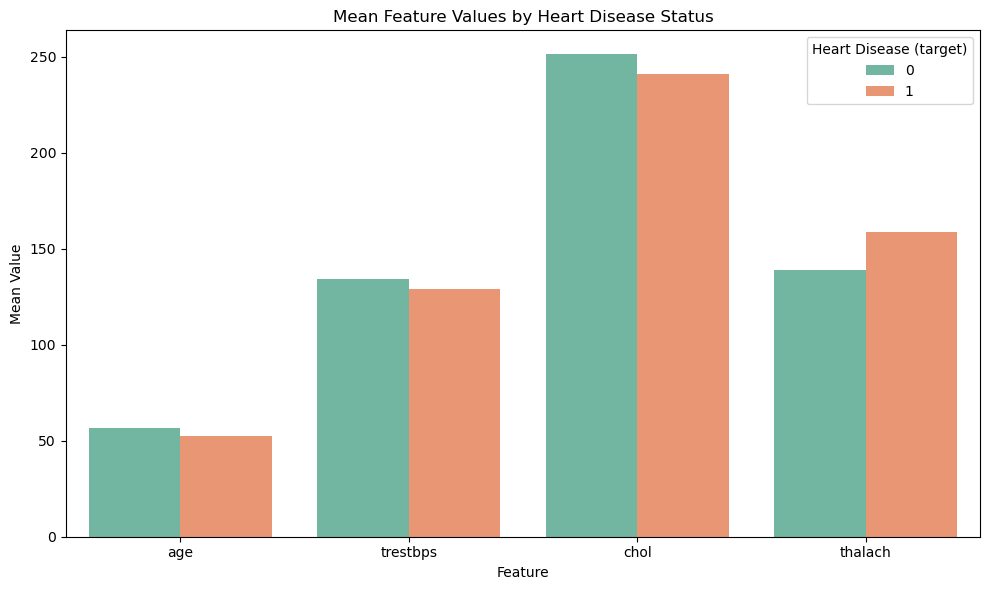

In [5]:
features_to_plot = ["age", "trestbps", "chol", "thalach"]

group_means = heart.groupby("target")[features_to_plot].mean().T

group_means_reset = group_means.reset_index().melt(id_vars="index", var_name="target", value_name="mean_value")
group_means_reset.rename(columns={"index": "feature"}, inplace=True)

plt.figure(figsize=(10, 6))
sns.barplot(data=group_means_reset, x="feature", y="mean_value", hue="target", palette="Set2")

plt.title("Mean Feature Values by Heart Disease Status")
plt.xlabel("Feature")
plt.ylabel("Mean Value")
plt.legend(title="Heart Disease (target)")
plt.tight_layout()
plt.show()


### 2. Unsupervised Machine Learning Dimensionality Reduction and Visualization


This section applies unsupervised learning techniques (**`t-distributed Stochastic Neighbor Embedding (t-SNE)`** and **`Principal Component Analysis (PCA)`**) to reduce dimensionality

These methods help reveal patterns and clusters that may separate between patients with and without heart disease.

Note the removal of the `target` label during transformation for these unsupervised methods

**Code Block 5:** Applies `t-SNE` to project the dataset into two dimensions for visualization. The scatterplot displays grouped patient data colored by heart disease status (`target` = 0 vs `target` = 1), revealing potential clustering patterns and nonlinear separability between healthy and affected individuals.


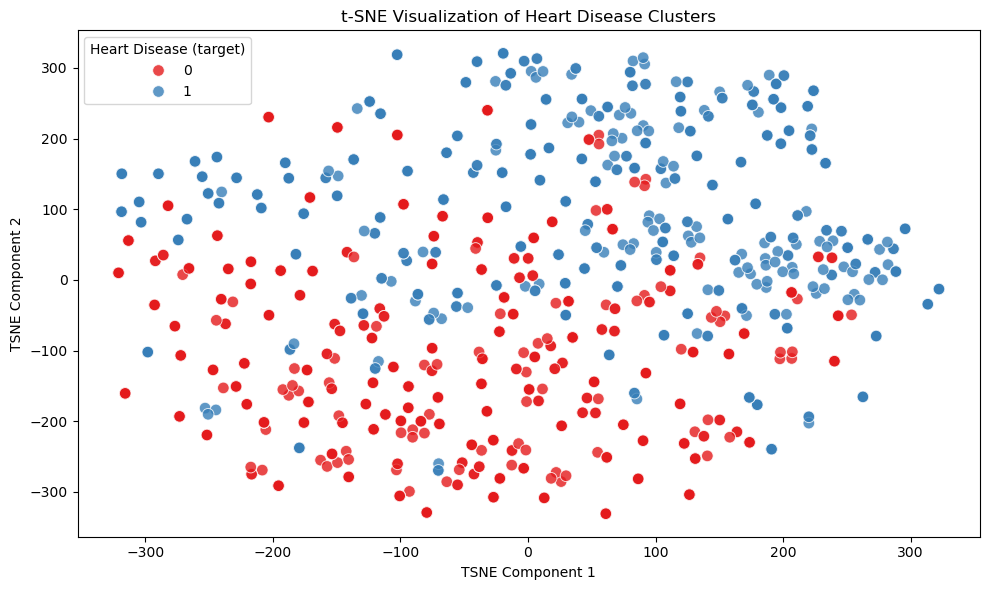

In [6]:
#heart.head(20)

from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler



X = heart.drop("target", axis=1)
y = heart["target"]

X_scaled = StandardScaler().fit_transform(X)


tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
X_embedded = tsne.fit_transform(X_scaled)


tsne_df = pd.DataFrame({
    "TSNE-1": X_embedded[:, 0],
    "TSNE-2": X_embedded[:, 1],
    "target": y
})


plt.figure(figsize=(10, 6))
sns.scatterplot(data=tsne_df, x="TSNE-1", y="TSNE-2", hue="target", palette="Set1", alpha=0.8, s=70)
plt.title("t-SNE Visualization of Heart Disease Clusters")
plt.xlabel("TSNE Component 1")
plt.ylabel("TSNE Component 2")
plt.legend(title="Heart Disease (target)")
plt.tight_layout()
plt.show()


**Code Block 6:** Performs `Principal Component Analysis (PCA)` on the standardized features to reduce dimensionality while retaining 95% of the dataset’s variance. 

This outputs the explained variance per principal component and visualizes the cumulative variance to assess how many components are needed to capture the majority of information.


**Note:** `PCA` is a linear dimensionality reduction technique that captures global variance across features. `t-SNE` is non-linear and focuses on preserving local structure, which may be more effective for visualizing complex relationships that PCA may overlook.


Explained variance by each component: [0.21369912 0.11971959 0.09238384 0.08994039 0.07685925 0.07479569
 0.06741785 0.05907578 0.05584142 0.04849683 0.04017354 0.0332042 ]


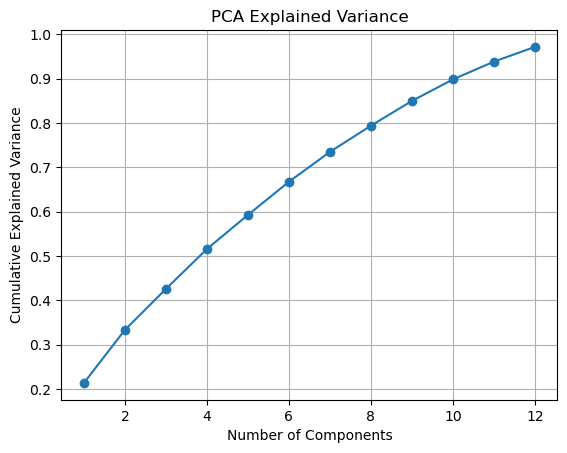

In [7]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X = heart.drop('target', axis=1)
y = heart['target']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=0.95)  
X_pca = pca.fit_transform(X_scaled)

explained_var = pca.explained_variance_ratio_
print("Explained variance by each component:", explained_var)


plt.plot(range(1, len(explained_var)+1), explained_var.cumsum(), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid(True)
plt.show()


**Code Block 7:** Visualizes the dataset projected onto the first two principal components (`PC1` and `PC2`). 

The scatterplot shows separation between heart disease classes (`target` = 0 vs `target` = 1)


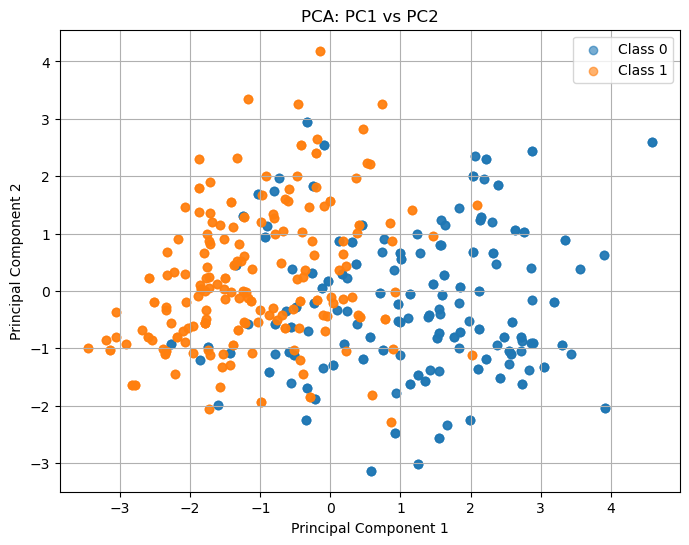

In [8]:

pc_df = pd.DataFrame(X_pca[:, :2], columns=['PC1', 'PC2'])
pc_df['target'] = y.values

plt.figure(figsize=(8,6))
for label in pc_df['target'].unique():
    subset = pc_df[pc_df['target'] == label]
    plt.scatter(subset['PC1'], subset['PC2'], label=f'Class {label}', alpha=0.6)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA: PC1 vs PC2')
plt.legend()
plt.grid(True)
plt.show()


**Code Block 8:** Extracts and ranks feature loadings for the first two principal components (`PC1`, `PC2`) to identify the top features contributing to the in each direction. 

This helps interpret which original features most influence the class separation.


In [9]:
import numpy as np
loading_matrix = pd.DataFrame(
    pca.components_[:2], 
    columns=X.columns,
    index=['PC1', 'PC2']
).T

loading_matrix['PC1_abs'] = loading_matrix['PC1'].abs()
loading_matrix['PC2_abs'] = loading_matrix['PC2'].abs()

top_pc1 = loading_matrix.sort_values(by='PC1_abs', ascending=False).head(5)
top_pc2 = loading_matrix.sort_values(by='PC2_abs', ascending=False).head(5)

print("Top contributors to PC1:")
print(top_pc1[['PC1']])

print("\nTop contributors to PC2:")
print(top_pc2[['PC2']])


Top contributors to PC1:
              PC1
oldpeak  0.421781
thalach -0.416970
slope   -0.380108
exang    0.363869
age      0.309574

Top contributors to PC2:
               PC2
trestbps  0.438909
age       0.398286
sex      -0.379076
chol      0.369819
fbs       0.321476


In [10]:
#!pip install xgboost

### 3. Supervised Machine Learning Classification with XGBoost

This section applies a supervised learning approach using **`XGBoost`** to predict heart disease status based on clinical features using the `target` label

Feature importances from XGBoost (e.g., Gain) help identify which variables most influence classification performance.

**Code Block 9:** Trains an `XGBoost` classifier on standardized heart disease data to model predictive relationships between features and the target outcome. 

This is a supervised learning approach (utilizing the `target` column) that complements the earlier unsupervised analyses (PCA, t-SNE) to assess feature importance and classification performance.


In [11]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


X = heart.drop('target', axis=1)
y = heart['target']


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


model = XGBClassifier(
    eval_metric='logloss',  
    random_state=42
)
model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

**Code Block 10:** Maps XGBoost’s internal feature codes to the original column names.

This will allow for the interpretation of feature importance for comparison to unsupervised methods


In [12]:
booster = model.get_booster()
importance_dict = booster.get_score(importance_type='gain')

importance_df = pd.DataFrame(
    list(importance_dict.items()),
    columns=['Feature', 'Gain']
).sort_values(by='Gain', ascending=False)

print("Top XGBoost features by Gain:")
print(importance_df.head(10))

feature_map = {f'f{i}': col for i, col in enumerate(X.columns)}

importance_df['Feature'] = importance_df['Feature'].map(feature_map)

print("Top XGBoost features by Gain (with real names):")
print(importance_df.head(10))

Top XGBoost features by Gain:
   Feature      Gain
2       f2  8.685804
12     f12  5.860433
11     f11  3.997101
10     f10  2.515409
8       f8  2.178755
9       f9  1.866358
1       f1  1.765807
7       f7  1.199223
0       f0  1.087513
4       f4  0.990401
Top XGBoost features by Gain (with real names):
    Feature      Gain
2        cp  8.685804
12     thal  5.860433
11       ca  3.997101
10    slope  2.515409
8     exang  2.178755
9   oldpeak  1.866358
1       sex  1.765807
7   thalach  1.199223
0       age  1.087513
4      chol  0.990401


**Code Block 11:** Top 10 predictive features ranked by XGBoost’s Gain metric. 


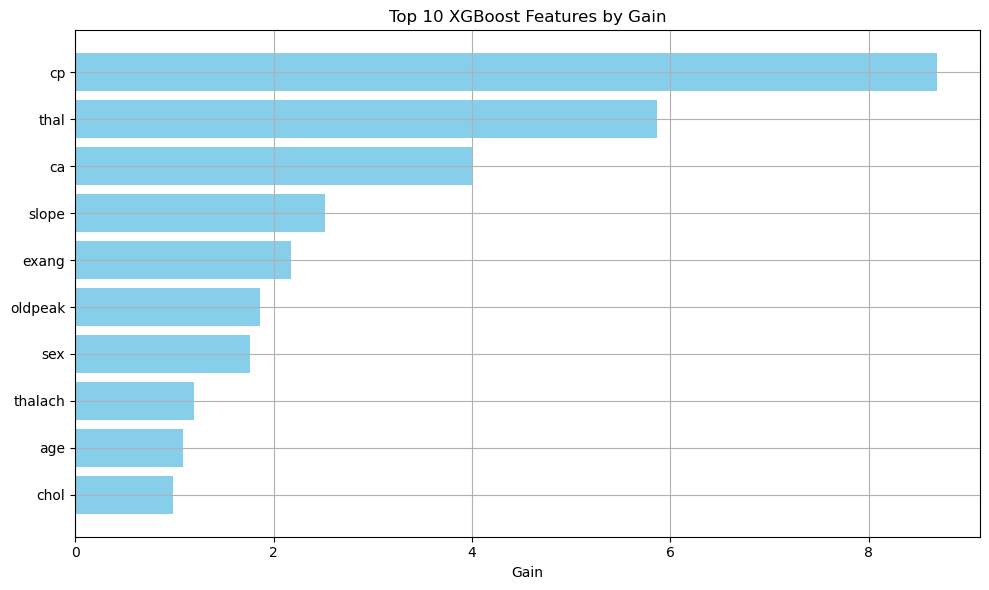

In [13]:
top_features = importance_df.head(10)
plt.figure(figsize=(10,6))
plt.barh(top_features['Feature'], top_features['Gain'], color='skyblue')
plt.xlabel('Gain')
plt.title('Top 10 XGBoost Features by Gain')
plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()
plt.show()
